## Penjelasan Implementasi

Import library yang dibutuhkan program

In [15]:
import pandas as pd
import numpy as np
import math
from sklearn.neural_network import MLPClassifier # neural network
from sklearn.model_selection import train_test_split
from sklearn import metrics

Berikut merupakan fungsi sigmoid berdasarkan rumus
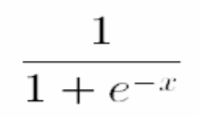
yang akan digunakan untuk perhitungan sigmoid di perceptron. 

In [16]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

Class Perceptron

Dalam kelas perceptron, terdapat beberapa parameter, yaitu
* data : list of data input yang akan diproses oleh perceptron
* weight : list of weight dari seluruh data input
* delta weight : list of delta weight dari seluruh data input
* rate : learning rate dari perceptron

init digunakan untuk menginisialisasi perceptron dengan data kosong, weight random, delta weight 0 dan learning rate sesuai yang diinput

input_data digunakan untuk menginput data ke perceptron 

calc_sigmoid digunakan pada proses feed forward untuk mengkalkulasi net dari suatu layer neuron, lalu berdasarkan net itu, mengkalkulasi output dari layer neuron tersebut dengan fungsi sigmoid

calc_delta digunakan saat backpropagation untuk menghitung delta dari suatu data berdasarkan rumus
![calc_delta](images/delta_hidden.png)

update_delta_weight saat backpropagation digunakan untuk memperbarui delta weight dari suatu data berdasarkan rumus
![update_delta_weight](images/delta_weight.png)

update_weight digunakan saat akhir batch untuk memperbarui weight dari suatu data berdasarkan rumus
![update_weight](images/weight.png)

In [17]:
class Perceptron:

    def __init__(self, rate, input_length):
        self.data = []
        self.weight = []
        self.delta_weight = []
        self.rate = rate

        random_matrix = np.random.randn(1, input_length) * np.sqrt(1 / input_length)
        for rand_array in random_matrix:
            for rand_num in rand_array:
                self.weight.append(rand_num)

        # print(self.weight)

        for inp in range(input_length):
            self.delta_weight.append(0)


    def input_data(self, data):
        self.data = []
        for datum in data:
            self.data.append(datum)

    def calc_sigmoid(self):
        jumlah = 0
        for i in range(len(self.data)):
            jumlah += self.data[i] * self.weight[i]
        self.output = sigmoid(jumlah)

    #for backprop
    def calc_delta(self, multiplier):
        self.delta = self.output * (1-self.output) * multiplier

    def update_delta_weight(self):
        for i in range(len(self.delta_weight)):
            self.delta_weight[i] += self.rate * self.delta * self.data[i]

    # End of batch-size
    def update_weight(self):
        for i in range(len(self.weight)):
            self.weight[i] += self.delta_weight[i]
            self.delta_weight[i] = 0

Class myMLP

Dalam kelas myMLP, terdapat beberapa atribut yaitu
* layers : list of data in a layer

* hidden_layer_sizes : list dari jumlah hidden layer yang ada pada 1 layer
* learning_rate : learning rate dari MLP
* max_iter : jumlah iterasi maksimum dari MLP
* error_treshold : batas error untuk mengakhiri proses MLP
* batch_size : ukuran batch sebelum MLP mengupdate weight dari data

fit digunakan untuk melakukan proses MLP berdasarkan input data dan target. Mulai dari inisialisasi data input sampai akhir dari 

update_all_weight digunakan untuk update semua weight dari seluruh perceptron dalam 1 layer

calculate_error digunakan untuk mengkalkulasi error berdasarkan squared error function
![calculate_error](images/calculate_error.png)

initialize_perceptrons_in_layer digunakan untuk memasukkan perceptron ke dalam layer berdasarkan input jumlah perceptron dan jumlah input

feed_forward digunakan untuk mengeksekusi feed forward. feed_forward akan mengkalkulasi net dan output dari suatu input data untuk satu layer, lalu memasukkan output sebagai input data untuk layer selanjutnya, dan mengulanginya untuk semua layer.

backward_prop digunakan untuk mengeksekusi backward propagation.
Untuk layer terakhir
1. Pertama, backward_prop akan mengecek jika hasil kelas output sama dengan target, jika sama, maka valuenya 1, jika beda, maka valuenya 0. 
2. Kedua, backward_prop akan menghitung diff, yaitu perbedaaan antara output dan target. 
3. Ketiga, backward_prop akan menghitung delta dari satu perceptron pada layer terakhir. 
4. Keempat, backward_prop akan memperbarui delta_weight dari satu perceptron pada layer terakhir. 
5. Kelima, backward_prop akan menambahkan total error berdasarkan error dari satu perceptron pada layer terakhir. Proses ini diulangi untuk semua perceptron yang ada pada layer terakhir.
Untuk hidden layer
1. backward_prop akan mengkalkulasi diff, yaitu delta dikali weight, untuk satu perceptron di satu layer.
2. backward_prop akan menghitung delta berdasarkan diff, untuk satu perceptron di satu layer.
3. backward_prop akan menghitung delta weight, untuk satu perceptron di satu layer.
4. backward prop akan mengulangi proses 1-3 untuk semua perceptron dalam satu layer.
5. Lalu, backward_prop akan mengulangi proses 1-4 untuk semua layer yang ada kecuali yang terakhir (karena layer yang terakhir adalah layer output)

predict digunakan untuk memprediksi nilai output dari data input

show_model digunakan untuk menampilkan hasil dari proses MLP

In [21]:
class myMLP:

    def __init__(self, hidden_layer_sizes=[2, 3], learning_rate=0.001, max_iter=200, error_treshold=0.0001, batch_size=32):
        # Attributes
        self.layers = []
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.error_treshold = error_treshold
        self.batch_size = batch_size
        self.output_print = []


    def fit(self, data_inputs, target):
        self.data_inputs = data_inputs
        self.target = target
        self.classes = self.target.unique()

        try:
            #
            number_of_inputs_from_previous_layer = len(self.data_inputs.columns)
            # Initialize perceptrons in the hidden layers (from index 1)
            for layer_idx in range(len(self.hidden_layer_sizes)):
                # hidden_layer = Array of perceptrons
                number_of_perceptrons_current_layer = self.hidden_layer_sizes[layer_idx]
                hidden_layer = self.initialize_perceptrons_in_layer(number_of_perceptrons_current_layer, number_of_inputs_from_previous_layer)
                number_of_inputs_from_previous_layer = self.hidden_layer_sizes[layer_idx]
                self.layers.append(hidden_layer)

            # Construct last (output) layer of perceptrons
            number_of_perceptrons_last_layer = len(self.target.unique())
            number_of_inputs_from_previous_layer = self.hidden_layer_sizes[-1]

            output_layer = self.initialize_perceptrons_in_layer(number_of_perceptrons_last_layer, number_of_inputs_from_previous_layer)
            self.layers.append(output_layer)

        except Exception as e:
            print(e)
            # Construct last (output) layer of perceptrons
            number_of_perceptrons_last_layer = len(self.target.unique())
            number_of_inputs_from_previous_layer = len(self.data_inputs.columns)
            output_layer = self.initialize_perceptrons_in_layer(number_of_perceptrons_last_layer, number_of_inputs_from_previous_layer)
            self.layers.append(output_layer)

        # Start feed forward and backward prop
        number_of_rows = len(data_inputs)
        for iteration in range(self.max_iter):
            error_total = 0
            for row in range(number_of_rows):
                # print("row")
                # print(row)
                self.feed_forward(row)

                # Do backward prop then get error
                error = self.backward_prop(row)
                error_total += error

                if (row % self.batch_size == 0):
                    self.update_all_weights()

            self.update_all_weights()

            if (error_total < self.error_treshold):
                break

    def update_all_weights(self):
        for layer in self.layers:
            for perceptron in layer:
                perceptron.update_weight()

    def calculate_error(self, diff):
        return 0.5 * (diff ** 2)

    def initialize_perceptrons_in_layer (self, number_of_perceptrons, number_of_inputs):
        layer = []
        for idx_perceptron in range(number_of_perceptrons):
            layer.append(Perceptron(self.learning_rate, number_of_inputs+1))
        return layer

    def feed_forward(self, row):
        inputs = []
        outputs = []
        # Initial inputs
        for column in self.data_inputs.columns:
            inputs.append(self.data_inputs[column][row])
        inputs.append(1)

        for layer_idx in range(len(self.layers)):
            outputs.clear()
            for perceptron in self.layers[layer_idx]:
                perceptron.input_data(inputs)
                perceptron.calc_sigmoid()
                outputs.append(perceptron.output)

            inputs.clear()
            for output_data in outputs:
                inputs.append(output_data)

            inputs.append(1)

    def backward_prop(self, row):
        # Last layer
        total_error = 0
        for i in range(len(self.layers[-1])):
            perceptron = self.layers[-1][i]
            # Calculate diff (multiplier):
            if self.classes[i] == self.target[row]:
                result = 1
            else:
                result = 0
            diff = result - perceptron.output
            perceptron.calc_delta(diff)
            perceptron.update_delta_weight()
            total_error += self.calculate_error(diff)

        # Hidden layers
        for layer_idx in range(len(self.layers)-1): #banyaknya layer di layers, kecuali output layer
            layer_size = len(self.layers[-layer_idx-2]) #banyaknya perceptron di layer itu
            for perc_idx in range(layer_size): #untuk setiap perceptron di layer itu
                diff = 0
                for next_perceptron in self.layers[-layer_idx-1]:

                    diff += next_perceptron.delta * next_perceptron.weight[perc_idx]
                self.layers[-layer_idx-2][perc_idx].calc_delta(diff)
                self.layers[-layer_idx-2][perc_idx].update_delta_weight()

        return total_error

    def predict(self, data_inputs):
        inputs = []
        outputs = []
        predictions = []
        for row in range(len(data_inputs)):
            inputs.clear()
            outputs.clear()
            # Initial inputs
            for column in data_inputs.columns:
                inputs.append(data_inputs[column][row])
            inputs.append(1)

            for layer_idx in range(len(self.layers)):
                outputs.clear()
                for perceptron in self.layers[layer_idx]:
                    perceptron.input_data(inputs)
                    perceptron.calc_sigmoid()
                    outputs.append(perceptron.output)
                inputs.clear()
                for output in outputs:
                    inputs.append(output)
                inputs.append(1)
            idx = outputs.index(max(outputs))
            predictions.append(self.classes[idx])
        return predictions

    def show_model(self, n=None):
        self.output_print.clear()
        for layer_idx in range(len(self.layers)):
            for perceptron_idx in range(len(self.layers[layer_idx])):
                for weight_idx in range(len(self.layers[layer_idx][perceptron_idx].weight)):
                    if (weight_idx != len(self.layers[layer_idx][perceptron_idx].weight) - 1):
                        self.output_print.append(str("Weight " + str(weight_idx) + "-" + "[" + str(layer_idx) + "][" + str(perceptron_idx) + "]: " + str(self.layers[layer_idx][perceptron_idx].weight[weight_idx])))
                    else:
                        self.output_print.append(str("Bias " + "[" + str(layer_idx) + "][" + str(perceptron_idx) + "]: " + str(self.layers[layer_idx][perceptron_idx].weight[weight_idx])))
        if (n is None):
            for output in self.output_print:
                print(output)
        else:
            for i in range(n):
                print(self.output_print[i])

## Hasil Eksekusi 
#### Show Model Menggunakan MyMLP

In [24]:
data = pd.read_csv("../iris.csv")

mlp = myMLP(max_iter = 400, hidden_layer_sizes=[100])

inputs = data.drop('species', axis = 1)
target = data['species']
mlp.fit(inputs,target)

print("Model (weights):")
mlp.show_model(20)

Model (weights):
Weight 0-[0][0]: -0.4580151997820117
Weight 1-[0][0]: 0.26475744134482393
Weight 2-[0][0]: 0.19413083964214112
Weight 3-[0][0]: 0.9841209730053799
Bias [0][0]: -0.16040992412317015
Weight 0-[0][1]: -0.15087269481839113
Weight 1-[0][1]: -0.17931566434434837
Weight 2-[0][1]: -0.018014981301583903
Weight 3-[0][1]: -0.026622233143138843
Bias [0][1]: -0.12008585149949502
Weight 0-[0][2]: 0.13131875213463318
Weight 1-[0][2]: -0.8379367221340386
Weight 2-[0][2]: 0.29490311522805884
Weight 3-[0][2]: 0.16299160576162983
Bias [0][2]: 1.0473466307064685
Weight 0-[0][3]: 0.8460822463289981
Weight 1-[0][3]: -0.39871982742906387
Weight 2-[0][3]: -0.87480389570237
Weight 3-[0][3]: -0.20236632895006668
Bias [0][3]: 0.06628263122138826


Penjelasan:

myMLP dijalankan dengan max iteration = 400 dan dengan hidden layer sebanyak 1 layer.
Pada hidden layer terdapat 100 perceptron.

Penulisan weight memiliki format sebagai berikut:
Weight <idx pada satu layer> - <idx layer> <idx perceptron>
    
Sebagai contoh,
Weight 0 - [0][0], artinya weight tersebut adalah weight dengan index pertama pada layer 0 (tersambung dengan perceptron index pertama pada layer 0)
    
Weight 2 - [0][3], artinya weight tersebut adalah weight dengan index terakhir pada layer 0 (tersambung dengan perceptron index terakhir pada layer 0)
    
Sedangkan, penulisan weight bias memiliki format sebagai berikut:
Bias [idx layer] [idx perceptron]
    
Sebagai contoh, Bias[0][3] = 0.066... , artinya weight bias pada perceptron index terakhir (idx = 3) pada layer 0 = 0.81...
    

Perhatikan bahwa penulisan weight dan bias dibatasi hingga 20 line saja.

### Pengukuran akurasi dengan split-test

In [26]:
df = pd.concat([inputs, target], axis=1)
train, test = train_test_split(df, test_size=0.3)

trainX = train[['sepal_length','sepal_width','petal_length','petal_width']] # taking the training data features
trainY = train.species # output of our training data
testX = test[['sepal_length','sepal_width','petal_length','petal_width']] # taking test data features
testY = test.species   # output value of test data

trainX = trainX.reset_index(drop=True)
trainY = trainY.reset_index(drop=True)
testX = testX.reset_index(drop=True)
testY = testY.reset_index(drop=True)

mlp2 = myMLP(max_iter = 400, hidden_layer_sizes=[100])
mlp2.fit(trainX, trainY)
prediction = mlp2.predict(testX)
val = 0
for i in range(len(prediction)):
    if prediction[i] == testY.values[i]:
        val += 1
print("Tested : " + str(len(prediction)))
print("True : " + str(val))
print("Accuracy : " + str(val/len(prediction)))

Tested : 45
True : 45
Accuracy : 1.0


Tercapai akurasi 100% pada saat iterasi maksimal = 400 dan hidden layer sizes = 100.

Jika max_iter dikurangi secara signifikan, akurasi akan menurun secara signifikan.

## Perbandingan dengan hasil MLP sklearn

### MLP sklearn

In [29]:
data = pd.read_csv("../iris.csv")
target = data[['species']].replace(['Iris-setosa','Iris-versicolor','Iris-virginica'],[0,1,2])
newData = data.drop('species', axis = 1)


clf1 = MLPClassifier(solver='sgd', batch_size=32, alpha=0, momentum=0, nesterovs_momentum=False, activation='logistic', max_iter=400, hidden_layer_sizes=(100))
clf1.fit(newData,target)

print("Model (weights)")
print(clf1.coefs_)

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model (weights)
[array([[-1.33616139e-01, -3.50243731e-02,  4.82251878e-02,
        -9.68239100e-03,  1.20706129e-01, -7.63841748e-05,
        -1.00917962e-01,  4.46000430e-02, -1.01620347e-01,
        -5.20572652e-02,  6.86854567e-02, -3.90038250e-02,
         3.95165888e-02, -5.96953397e-02, -1.01279840e-01,
        -1.07700806e-01, -8.60459367e-02, -7.39446813e-03,
         1.04648626e-01, -4.38570644e-02, -3.77053053e-02,
        -1.10598128e-01,  1.05199949e-01,  2.81923966e-02,
         9.30548773e-02, -1.27449022e-01, -1.86417192e-02,
        -4.68677197e-02, -1.02897751e-01,  9.46236401e-02,
         6.59121747e-02,  9.18164693e-02, -4.07688013e-02,
        -9.53157826e-02, -6.25917297e-02,  5.76587586e-02,
         6.52339345e-02, -1.04505247e-01, -1.34404460e-02,
        -4.91626267e-02, -9.18166980e-03,  9.14139216e-02,
        -9.96553936e-02, -1.02545903e-01,  1.24502219e-02,
         1.01853783e-01,  1.07400344e-01, -5.06523690e-02,
         9.76630457e-02,  6.96672873e-0

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Contoh cara membaca weight
-1.33616139e-01 adalah weight pertama yang tersambung pada perceptron pertama pada hidden layer pertama.
-3.50243731e-02 adalah weight pertama yang tersambung pada perceptron kedua pada  hidden layer pertama.
4.82251878e-02 adalah weight pertama yang tersambung pada perceptron ketiga pada hidden layer pertama.
-9.68239100e-03 adalah weight pertama yang tersambung pada perceptron keempat pada hidden layer pertama.

1.20706129e-01 adalah weight kedua yang tersambung pada perceptron pertama pada hidden layer pertama.
4.46000430e-02 adalah weight kedua yang tersambung pada perceptron kedua pada hidden layer kedua.

dan seterusnya...

Setiap layer dibedakan dengan index matriks. Contohnya, weight dari input layer ke hidden layer pertama terkandung dalam matriks pertama (idx = 0)

Perhatikan bahwa weight yang disebutkan berbeda dengan MyMLP karena cara inisialisasi weight yang berbeda. 
Sumber scikit-learn menginisiasi weight: <br> 
#### Glorot, X. & Bengio, Y.. (2010). Understanding the difficulty of training deep feedforward neural networks. Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics, in PMLR 9:249-256

### Pengukuran Akurasi

In [33]:
df = pd.concat([newData, target], axis=1)
train, test = train_test_split(df, test_size=0.3)
trainX = train[['sepal_length','sepal_width','petal_length','petal_width']] # taking the training data features
trainY = train.species #output of our training data
testX = test[['sepal_length','sepal_width','petal_length','petal_width']] # taking test data features
testY = test.species   #output value of test data

clf2 = MLPClassifier(solver='sgd', batch_size=32, alpha=0, momentum=0, nesterovs_momentum=False, activation='logistic', max_iter=400, hidden_layer_sizes=(100))
clf2.fit(trainX, trainY)

prediction = clf2.predict(testX)
print('The accuracy of the Multi-layer Perceptron is:',metrics.accuracy_score(prediction,testY))

The accuracy of the Multi-layer Perceptron is: 0.6444444444444445


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Perhatikan bahwa akurasi scikit learn dalam mengklasifikasikan data kalah dibandingkan MyMLP.